# Algoritmos para detectar anomalías en bases de datos
Autor: NQuiros 

Reviso: NTripp

Aprobado: RMarino

Versión: 1

***
Modelos de librerías scikit-learn

Datos de prueba: duraznos (curso de PyE)


Librerías necesarias: 
- `pandas` manejo de datos
- `numpy` soporte para arreglos multidimensionales y métodos numéricos
- `matplotlib` y `seaborn` visualizar resultados
- `sklearn` modelos de inteligencia artificial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
#import scikitplot as skplt 

Inicializamos el generador de números pseudo-aleatorios con una semilla determinada para que el **trabajo sea reproducible**.

In [2]:
np.random.seed(123);

## Carga de datos

Importamos las observaciones desde un archivo en formato `csv` y presentamos los primeros registros del dataframe.

In [19]:
datosCrudos = pd.read_csv("duraznosfinal.csv");
#Eliminamos la primer columna que no nos aporta nada.
datosCrudos.drop(datosCrudos.columns[0],axis = 1, inplace = True)
datosCrudos.head()

,Zona,Finca,Peso,Diámetro Sutural,Diámetro Contrasutural
0,1.0,301,147,64.0,67.0
1,1.0,1502,87,57.0,53.0
2,1.0,301,139,65.0,64.0
3,1.0,301,159,69.0,67.0
4,1.0,1502,128,64.0,62.0


Revisamos los datos importados.

In [20]:
datosCrudos.describe()

,Zona,Finca,Peso,Diámetro Sutural,Diámetro Contrasutural
count,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000
mean,1.809444,7603.602024,129.191400,62.140556,62.598651
std,0.892034,14989.460142,43.354427,6.007568,6.981575
min,1.000000,101.000000,10.000000,37.000000,42.000000
25%,1.000000,301.000000,104.000000,58.000000,58.000000
50%,1.000000,1032.000000,130.000000,62.400000,63.000000
75%,3.000000,1502.000000,157.000000,66.250000,68.000000
max,3.000000,40901.000000,255.000000,79.600000,86.100000


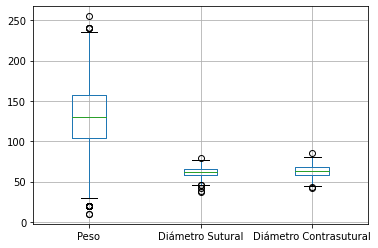

In [21]:
datosCrudos.loc[:,["Peso","Diámetro Sutural","Diámetro Contrasutural"]].boxplot();

In [22]:
datosCrudos.count()

Zona                      1186
Finca                     1186
Peso                      1186
Diámetro Sutural          1186
Diámetro Contrasutural    1186
dtype: int64

Veamos cómo se relaciona el peso con la numeración de las fincas.

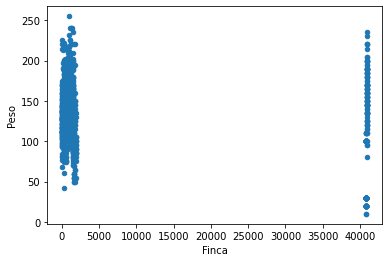

In [23]:
datosCrudos.plot.scatter(x="Finca",y="Peso");

Hay un grupo de fincas con numeración bastante alejada del resto. Además, en las fincas con numeración más alta hay pesos registrados bastante por debajo del resto (esquina inferior derecha del gráfico).

## Etiquetado de valores atípicos verdaderos

En estos datos de prueba sabemos que los duraznos con pesos inferiores a 40 gramos tuvieron un problema y se registraron con un error. Vamos a etiquetarlos para probar los algoritmos de detección.

In [24]:
#Aplicamos un "filtro booleano" a todo el dataframe bajo la condición de que el peso es menor a 40 gramos.
atipicos=datosCrudos["Peso"]<40;
datosCrudos[atipicos]

,Zona,Finca,Peso,Diámetro Sutural,Diámetro Contrasutural
607,2.0,40801,20,54.0,54.0
618,2.0,40801,20,49.0,45.0
624,2.0,40801,30,49.0,49.0
626,2.0,40801,30,54.0,54.0
639,2.0,40801,30,51.0,49.0
...,...,...,...,...,...
1141,2.0,40801,30,50.0,51.0
1149,2.0,40801,30,49.0,49.0
1158,2.0,40801,20,50.0,48.0
1165,2.0,40801,30,52.0,52.0


In [25]:
atipicos=atipicos.rename("Atípicos")

Vemos que los pesos etiquetados corresponden a la finca 40801.

In [26]:
#concatenamos como columnas
datosTrabajo=pd.concat([datosCrudos,atipicos], axis=1, join="outer")
datosTrabajo.head()

,Zona,Finca,Peso,Diámetro Sutural,Diámetro Contrasutural,Atípicos
0,1.0,301,147,64.0,67.0,False
1,1.0,1502,87,57.0,53.0,False
2,1.0,301,139,65.0,64.0,False
3,1.0,301,159,69.0,67.0,False
4,1.0,1502,128,64.0,62.0,False


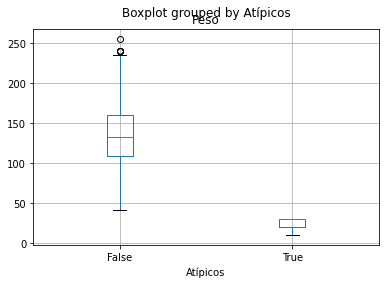

In [27]:
datosTrabajo.boxplot("Peso",by="Atípicos");

## Prueba de los modelos

Ahora que tenemos los datos limpios podemos empezar a utilizar modelos. Y comparar su desempeño.

Vamos a utilizar las variables "Peso", "Diámetro Sutural" y "Diámetro Contrasutural" para estudiar los conglomerados. 

Vamos a verificar las predicciones con la variable "Atípicos".

Probamos primero con *KNN* una forma de aprendizaje no supervisado.

In [28]:
#Librerias para KNN.
from pyod.models.knn import KNN 
from sklearn.model_selection import train_test_split 
from pyod.utils.data import evaluate_print

ModuleNotFoundError: No module named 'pyod'

In [ ]:
# Elegimos las variables
x = datosTrabajo.drop(['Zona','Finca','Clasificacion'], axis=1) 
y = datosTrabajo["Atípicos"]

# show the shape of x and y  
# print("x shape: {}".format(x.shape)) 
# print("y shape: {}".format(y.shape))

In [ ]:
#Vamos a analizar el peso y cuales son outliers
#Mantenemos la notacion de x como input e y como output.
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, stratify = y, random_state = 42)

print(f"x_train : {x_train.size},\n x_test: {len(x_test)},\n y_train: {len(y_train)},\n y_test :{len(y_test)}")

In [ ]:
clf_knn = KNN(contamination= 0.172,n_neighbors = 5,n_jobs=-1)
#Entrenamos el modelo con datos de entrenamiento
clf_knn.fit(x_train)


In [ ]:
#Esto nos devuelve las etiquetas del entrenamiento de los datos
y_train_pred = clf_knn.labels_
#Obtenemos su puntaje
y_train_scores = clf_knn.decision_scores_
print(f"y_train : {y_train.size}, y_train_scores:{y_train_scores.size}")

In [ ]:
# Evaluate on the training data 
evaluate_print('KNN', y_train, y_train_scores)

In [ ]:
# plot the comfusion matrix  in the train set 

skplt.metrics.plot_confusion_matrix(y_train,y_train_pred, 
                                    normalize=False,
                                    title="Consfusion Matrix on Train Set")
plt.show()

In [ ]:
y_test_scores = clf_knn.decision_function(x_test)  # outlier scores
# Evaluate on the training data
evaluate_print('KNN', y_test,y_test_scores)

In [ ]:
# plot the comfusion matrix  in the test set
y_preds = clf_knn.predict(x_test)

skplt.metrics.plot_confusion_matrix(y_test,y_preds, normalize=False,
                                    title="Consfusion Matrix on Test Set")
plt.show()

Como podemos observar el KNN ROC en ambos casos es bastante pobre. Mis dos teorias son:

    1.Los datos son muy pocos para un correcto entrenamiento de la IA
    2.Puede que el clasificador este funcionando mal, osea que los datos esten mal clasificados antes del entrenamiento. Entonces por eso sea malo el entrenamiento.

